In [102]:
#import the required libraries
import torch
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader

Download and load the dataset: Fashion-MNIST

In [103]:
#block1
#load the dataset
train_dataset = FashionMNIST(root='/Users/dimashpak/Desktop/HW3/', train=True, download=True, transform=transforms.ToTensor())
test_dataset = FashionMNIST(root='/Users/dimashpak/Desktop/HW3/', train=False, download=True, transform=transforms.ToTensor())

#checking the number of examples in the training and test data
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

Number of training samples: 60000
Number of test samples: 10000


Preprocessing

In [104]:
#block2
#calculate mean and std for normalization
temp_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)

mean = 0.0
std = 0.0
total_samples = 0

for images, _ in temp_loader:
    batch_samples = images.size(0) #number of images in the batch
    images = images.view(batch_samples, -1) #flatten the images
    mean += images.mean(1).sum() #sum of the means
    std += images.std(1).sum() #sum of the standard deviations
    total_samples += batch_samples

mean /= total_samples
std /= total_samples

print(f"Calculated mean: {mean}")
print(f"Calculated std: {std}")

#define transformations with normalization and resizing
transform = transforms.Compose([
    transforms.Resize((32, 32)), #resize image to 32X32
    transforms.ToTensor(), #convert image to PyTorch tensors
    transforms.Normalize((mean.item(),), (std.item(),)) #normalize with calculated mean and std
])

#reload datasets with transformations
train_dataset = FashionMNIST(root='/Users/dimashpak/Desktop/HW3/', train=True, download=True, transform=transform)
test_dataset = FashionMNIST(root='/Users/dimashpak/Desktop/HW3/', train=False, download=True, transform=transform)

#checking the number of examples in the training and test data
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

#display  a transformed image example
image, label = train_dataset[0]
print(f"Transformed image size: {image.size()}")
print(f"Label: {label}")


Calculated mean: 0.2860407531261444
Calculated std: 0.320453405380249
Number of training samples: 60000
Number of test samples: 10000
Transformed image size: torch.Size([1, 32, 32])
Label: 9


Data amplification

In [105]:
#block3
#define transformations with Data Augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  #random horizontal flip
    transforms.RandomRotation(15),          #random rotation up to 15 degrees
    transforms.Resize((32, 32)),            #resize image to 32x32
    transforms.ToTensor(),                  #convert image to PyTorch tensors
    transforms.Normalize((mean.item(),), (std.item(),))  #normalize with calculated mean and std
])

test_transform = transforms.Compose([
    transforms.Resize((32, 32)),            #resize image to 32x32
    transforms.ToTensor(),                  #convert image to PyTorch tensors
    transforms.Normalize((mean.item(),), (std.item(),))  #normalize with calculated mean and std
])

#reload datasets with new transformations
train_dataset = FashionMNIST(root='/Users/dimashpak/Desktop/HW3/', train=True, download=True, transform=train_transform)
test_dataset = FashionMNIST(root='/Users/dimashpak/Desktop/HW3/', train=False, download=True, transform=test_transform)

#check the updated datasets
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")


Number of training samples: 60000
Number of test samples: 10000


Building the model

architecture:

In [106]:
#block4
#define the CNN model
import torch.nn as nn

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        #first convolutional layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        #second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        #fully connected layers
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        #dropout
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.conv1(x)))  #conv1 -> ReLU -> Pool
        x = self.pool(nn.ReLU()(self.conv2(x)))  #conv2 -> ReLU -> Pool
        x = x.view(-1, 64 * 8 * 8)               #flatten the feature map
        x = nn.ReLU()(self.fc1(x))              #fully connected -> ReLU
        x = self.dropout(x)                     #apply Dropout
        x = self.fc2(x)                         #fully connected for classification
        return x

#initialize the model
model = CNNModel()
print(model)


CNNModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


Model complexity

In [107]:
#block5
#analyze model complexity
from torchsummary import summary

#analyze the model with input size (1, 32, 32) for Fashion-MNIST
summary(model, input_size=(1, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             320
         MaxPool2d-2           [-1, 32, 16, 16]               0
            Conv2d-3           [-1, 64, 16, 16]          18,496
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Linear-5                  [-1, 128]         524,416
           Dropout-6                  [-1, 128]               0
            Linear-7                   [-1, 10]           1,290
Total params: 544,522
Trainable params: 544,522
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.47
Params size (MB): 2.08
Estimated Total Size (MB): 2.55
----------------------------------------------------------------


Training

Initial parameters

In [108]:
#block6.0
from sklearn.model_selection import ParameterSampler
import random

# Define parameter grid
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],  # קצב למידה
    'batch_size': [32, 64, 128],          # גודל מנות
    'num_epochs': [10, 15, 20]           # מספר אפוקים
}

# Generate random parameter combinations
param_combinations = list(ParameterSampler(param_grid, n_iter=5, random_state=42))

print("Randomly selected parameter combinations:")
for params in param_combinations:
    print(params)


Randomly selected parameter combinations:
{'num_epochs': 20, 'learning_rate': 0.1, 'batch_size': 32}
{'num_epochs': 15, 'learning_rate': 0.01, 'batch_size': 64}
{'num_epochs': 10, 'learning_rate': 0.001, 'batch_size': 64}
{'num_epochs': 10, 'learning_rate': 0.01, 'batch_size': 128}
{'num_epochs': 10, 'learning_rate': 0.001, 'batch_size': 32}


In [109]:
#block6
#define training parameters
learning_rate = 0.001  #initial learning rate
batch_size = 64        #number of samples per batch
num_epochs = 10        #number of epochs to train the model

#prepare DataLoaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training with batch size: {batch_size}, learning rate: {learning_rate}, for {num_epochs} epochs.")


Training with batch size: 64, learning rate: 0.001, for 10 epochs.


Loss function optimizer

In [110]:
#block7
#define loss function and optimizer
import torch.optim as optim

#loss function
criterion = nn.CrossEntropyLoss()

#optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print("Loss function and optimizer are set.")

#define a learning rate scheduler
from torch.optim.lr_scheduler import StepLR

#initialize the scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

print("Learning rate scheduler is set.")



Loss function and optimizer are set.
Learning rate scheduler is set.


In [111]:
#block8
# Initialize lists to store loss and accuracy
train_losses = []
train_accuracies = []
val_accuracies = []


Training loop

In [112]:
#block9
#training loop
for epoch in range(num_epochs):
    model.train()  #set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        #move data to the device (if using GPU)
        images, labels = images.to('cpu'), labels.to('cpu')
        
        #zero the gradients
        optimizer.zero_grad()
        
        #forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        #backward pass and optimization
        loss.backward()
        optimizer.step()
        
        #update running loss
        running_loss += loss.item()
        
        #calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        #print progress every 100 batches
        if (batch_idx + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
    
    # Store training loss and accuracy
    train_losses.append(running_loss / len(train_loader))  # Average loss for epoch
    train_accuracies.append(100 * correct / total)  # Training accuracy

    # Evaluate the model on validation set
    model.eval()
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for val_images, val_labels in test_loader:
            val_images, val_labels = val_images.to('cpu'), val_labels.to('cpu')
            val_outputs = model(val_images)
            _, val_predicted = torch.max(val_outputs.data, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

    val_accuracies.append(100 * val_correct / val_total)  # Validation accuracy

    #print loss for the epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {running_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, Validation Accuracy: {val_accuracies[-1]:.2f}%")

    # Update learning rate
    scheduler.step()
    print(f"Learning rate after epoch {epoch+1}: {scheduler.get_last_lr()}")


Epoch [1/10], Step [100/938], Loss: 0.6629
Epoch [1/10], Step [200/938], Loss: 0.5961
Epoch [1/10], Step [300/938], Loss: 0.5000
Epoch [1/10], Step [400/938], Loss: 0.7648
Epoch [1/10], Step [500/938], Loss: 0.5008
Epoch [1/10], Step [600/938], Loss: 0.4748
Epoch [1/10], Step [700/938], Loss: 0.6125
Epoch [1/10], Step [800/938], Loss: 0.6095
Epoch [1/10], Step [900/938], Loss: 0.6436
Epoch [1/10] Loss: 0.6556, Train Accuracy: 75.84%, Validation Accuracy: 83.40%
Learning rate after epoch 1: [0.001]
Epoch [2/10], Step [100/938], Loss: 0.4539
Epoch [2/10], Step [200/938], Loss: 0.3647
Epoch [2/10], Step [300/938], Loss: 0.5299
Epoch [2/10], Step [400/938], Loss: 0.5156
Epoch [2/10], Step [500/938], Loss: 0.4020
Epoch [2/10], Step [600/938], Loss: 0.5568
Epoch [2/10], Step [700/938], Loss: 0.5664
Epoch [2/10], Step [800/938], Loss: 0.3962
Epoch [2/10], Step [900/938], Loss: 0.5967
Epoch [2/10] Loss: 0.4747, Train Accuracy: 82.80%, Validation Accuracy: 86.58%
Learning rate after epoch 2: [0

In [113]:
#block9.1
#loop through random parameter combinations
results = []

for params in param_combinations:
    print(f"Testing parameters: {params}")
    
    #extract parameters
    learning_rate = params['learning_rate']
    batch_size = params['batch_size']
    num_epochs = params['num_epochs']
    
    #prepare DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    #initialize model, optimizer, and scheduler
    model = CNNModel()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
    criterion = nn.CrossEntropyLoss()

    #training loop
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to('cpu'), labels.to('cpu')
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        scheduler.step()

    #evaluate the model
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to('cpu'), labels.to('cpu')
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    results.append((params, accuracy))
    print(f"Parameters: {params}, Accuracy: {accuracy:.2f}%")

#print results
print("\nAll results:")
for params, accuracy in results:
    print(f"Parameters: {params}, Accuracy: {accuracy:.2f}%")

#finding the best parameters
best_params, best_accuracy = max(results, key=lambda x: x[1])
print("\nBest Parameters:")
print(best_params)
print(f"Best Validation Accuracy: {best_accuracy:.2f}%")


Testing parameters: {'num_epochs': 20, 'learning_rate': 0.1, 'batch_size': 32}
Parameters: {'num_epochs': 20, 'learning_rate': 0.1, 'batch_size': 32}, Accuracy: 10.00%
Testing parameters: {'num_epochs': 15, 'learning_rate': 0.01, 'batch_size': 64}
Parameters: {'num_epochs': 15, 'learning_rate': 0.01, 'batch_size': 64}, Accuracy: 85.31%
Testing parameters: {'num_epochs': 10, 'learning_rate': 0.001, 'batch_size': 64}
Parameters: {'num_epochs': 10, 'learning_rate': 0.001, 'batch_size': 64}, Accuracy: 90.54%
Testing parameters: {'num_epochs': 10, 'learning_rate': 0.01, 'batch_size': 128}
Parameters: {'num_epochs': 10, 'learning_rate': 0.01, 'batch_size': 128}, Accuracy: 86.56%
Testing parameters: {'num_epochs': 10, 'learning_rate': 0.001, 'batch_size': 32}
Parameters: {'num_epochs': 10, 'learning_rate': 0.001, 'batch_size': 32}, Accuracy: 90.95%

All results:
Parameters: {'num_epochs': 20, 'learning_rate': 0.1, 'batch_size': 32}, Accuracy: 10.00%
Parameters: {'num_epochs': 15, 'learning_ra

Learning pace timing

In [114]:
#block10
#evaluate the model
def evaluate_model(model, test_loader):
    model.eval()  #set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  #no need to calculate gradients
        for images, labels in test_loader:
            #move data to the device (if using GPU)
            images, labels = images.to('cpu'), labels.to('cpu')
            
            #forward pass
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            #update total and correct predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f'Accuracy on the test dataset: {accuracy:.2f}%')
    return accuracy

#call the evaluation function
test_accuracy = evaluate_model(model, test_loader)


Accuracy on the test dataset: 90.95%


Assessment

Model testing

In [115]:
#block11
#evaluate model with additional metrics
from sklearn.metrics import classification_report, confusion_matrix

#evaluate the model on test dataset and compute additional metrics
def evaluate_model_with_metrics(model, test_loader):
    model.eval()  #set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  #no need to calculate gradients during evaluation
        for images, labels in test_loader:
            images, labels = images.to('cpu'), labels.to('cpu')
            
            #forward pass
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            #collect predictions and true labels
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    #calculate metrics
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

    #confusion Matrix (Optional)
    print("Confusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))

#call the evaluation function with metrics
evaluate_model_with_metrics(model, test_loader)


Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.84      0.86      0.85      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.86      0.88      0.87      1000
       Dress       0.91      0.91      0.91      1000
        Coat       0.84      0.89      0.87      1000
      Sandal       0.99      0.97      0.98      1000
       Shirt       0.76      0.69      0.72      1000
     Sneaker       0.93      0.97      0.95      1000
         Bag       0.98      0.98      0.98      1000
  Ankle boot       0.97      0.95      0.96      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

Confusion Matrix:
[[864   1  18  19   3   1  85   0   9   0]
 [  1 983   0  12   0   0   4   0   0   0]
 [ 16   1 880   6  46   0  51   0   0   0]
 [ 18   2  10 912  26   0  32   0   0   0]
 [  0   1  41  24 893   0  4

Confusion matrix

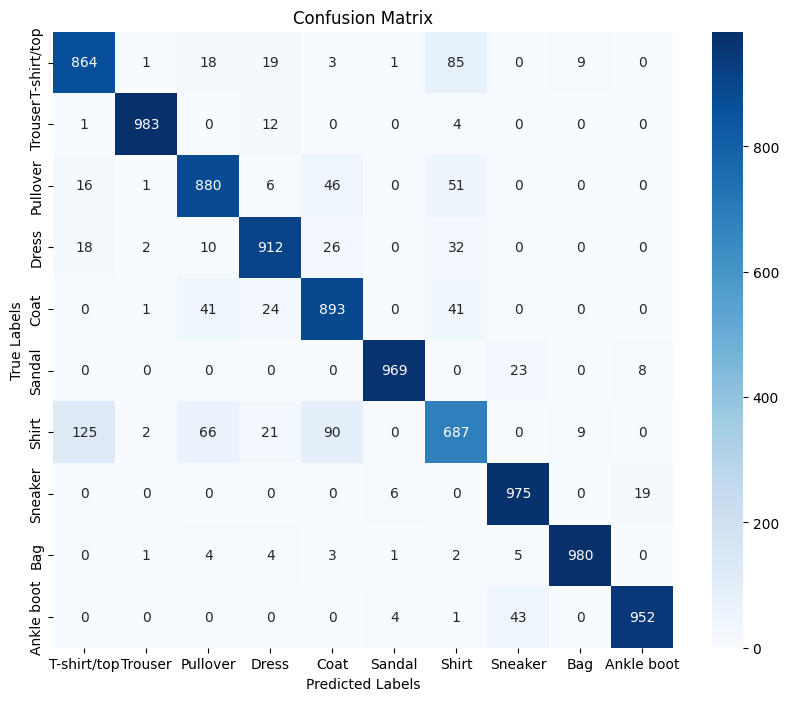

In [116]:
#block12
#display Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

#function to plot the confusion matrix
def plot_confusion_matrix(model, test_loader, class_names):
    model.eval()  #set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to('cpu'), labels.to('cpu')
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    #compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    #plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

#call the function to display the confusion matrix
plot_confusion_matrix(model, test_loader, class_names=test_dataset.classes)


Visualization

Filters and feature maps

Visualizing filters from the first convolutional layer:


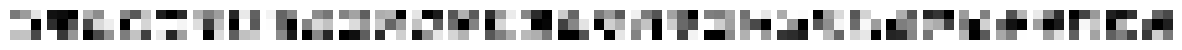

Visualizing feature maps for the first test image:


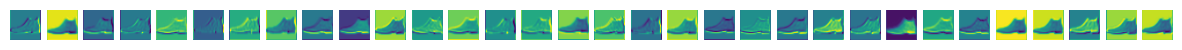

In [117]:
#block13
#visualize filters and feature maps
import matplotlib.pyplot as plt

#function to visualize filters of a convolutional layer
def visualize_filters(layer):
    weights = layer.weight.data.cpu().numpy()
    num_filters = weights.shape[0]
    fig, axes = plt.subplots(1, num_filters, figsize=(15, 15))
    for i in range(num_filters):
        ax = axes[i]
        ax.imshow(weights[i, 0, :, :], cmap='gray')
        ax.axis('off')
    plt.show()

#function to visualize feature maps for a given input
def visualize_feature_maps(model, image):
    model.eval()
    with torch.no_grad():
        #pass the image through the first convolutional layer
        x = model.conv1(image.unsqueeze(0))
        feature_maps = x.squeeze(0).cpu().numpy()

    num_maps = feature_maps.shape[0]
    fig, axes = plt.subplots(1, num_maps, figsize=(15, 15))
    for i in range(num_maps):
        ax = axes[i]
        ax.imshow(feature_maps[i, :, :], cmap='viridis')
        ax.axis('off')
    plt.show()

#visualize filters of the first convolutional layer
print("Visualizing filters from the first convolutional layer:")
visualize_filters(model.conv1)

#visualize feature maps for the first test image
print("Visualizing feature maps for the first test image:")
test_image, _ = test_dataset[0]
visualize_feature_maps(model, test_image)


Training curves

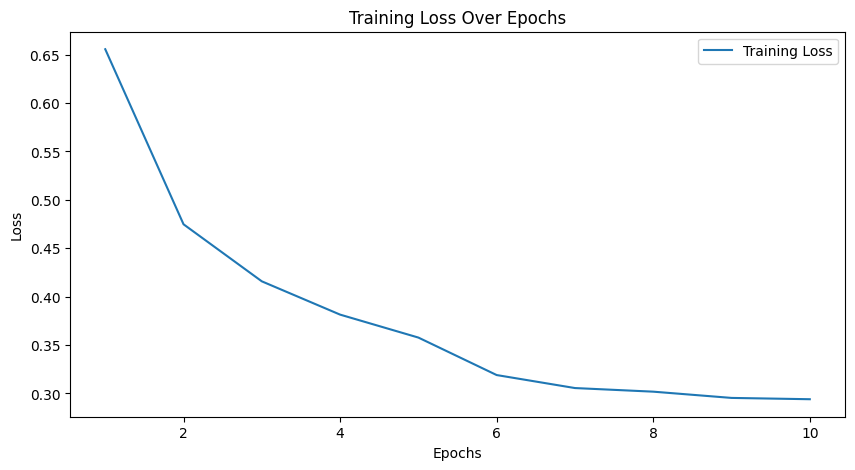

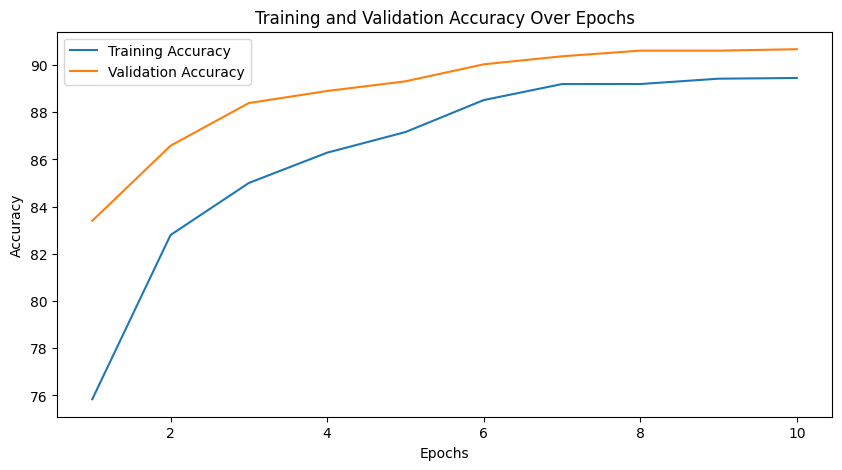

In [118]:
#block14
#plot training and validation curves
import matplotlib.pyplot as plt

#plot Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

#plot Accuracy Curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()


Parameter setting